# Time Series Forecasting in TensorFlow 
In this notebook, a series of models are built in an attempt to predict the power, which mainly covers the following topics:


*   Get time series data
*   Format data for a time series problem
*   Evaluating a time series forecasting model
*   Setting up a series of deeping learning modelling experiments


*   Making predictions (forecasts) with a time series model
*   Creating prediction intervals for time series model forecasts



# Setup

In [59]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn import metrics as skm
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import plot_model

# Get time series data and preprocess

In [60]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plot a timesteps (a series of points in time) against values (a series values across timesteps).

  Args:
    timesteps: array of timesteps.
    values: array of values across timesteps.
    format: style of plot, default to ".".
    start: where to start the plot (setting a value for the index of timesteps & values start from)
    ens: where to end the plot (setting a value for the index of timesteps & values end at)
    label: label to show on plot of values
  """
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel('Date')
  plt.ylabel('power')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

In [61]:
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  MASE = mae/mae_naive_no_season

  return MASE

In [ ]:
def evaluate_preds(y_true, y_pred):
  """Compute evaluation metrics for predictions.

  Uses sklearn metrics on numpy arrays to avoid compatibility issues with tf.keras.metrics.
  Returns a dict with MAE, MSE, RMSE, MAPE and MASE as Python floats.
  """
  y_true_arr = np.asarray(y_true).astype(float)
  y_pred_arr = np.asarray(y_pred).astype(float)

  mae = skm.mean_absolute_error(y_true_arr, y_pred_arr)
  mse = skm.mean_squared_error(y_true_arr, y_pred_arr)
  rmse = np.sqrt(mse)

  
  try:
    mape = skm.mean_absolute_percentage_error(y_true_arr, y_pred_arr) * 100.0
  except Exception:
    # fallback: manual safe MAPE
    eps = 1e-8
    mape = np.mean(np.abs((y_true_arr - y_pred_arr) / np.maximum(np.abs(y_true_arr), eps))) * 100.0


  mase = mean_absolute_scaled_error(tf.constant(y_true_arr, dtype=tf.float32), tf.constant(y_pred_arr, dtype=tf.float32)).numpy()


  if hasattr(mae, "__len__") and np.ndim(mae) > 0:
    mae = np.mean(mae)
  if hasattr(mse, "__len__") and np.ndim(mse) > 0:
    mse = np.mean(mse)
  if hasattr(rmse, "__len__") and np.ndim(rmse) > 0:
    rmse = np.mean(rmse)
  if hasattr(mape, "__len__") and np.ndim(mape) > 0:
    mape = np.mean(mape)
  if hasattr(mase, "__len__") and np.ndim(mase) > 0:
    mase = np.mean(mase)

  metrics = {'MAE': float(mae),
             'MSE': float(mse),
             'RMSE': float(rmse),
             'MAPE': float(mape),
             'MASE': float(mase)}
  return metrics

In [63]:
# Import time series data with Pandas and parse dates
power = pd.read_csv("../data/NLTP_F_DAILY_Makkah.csv")
power.head()
power=power[['Date','System_City_Calculated']].rename(columns={'System_City_Calculated': 'power'})
power.index=pd.DatetimeIndex(power['Date'])
power.drop('Date',inplace=True,axis=1)

In [64]:
pop = pd.read_csv("../data/pop - csvData.csv")
pop


,year,population,growthRate,Makkah,Total_GDP
0,2011,1590484,0.0308,7.244429e+06,2178792
1,2012,1639512,0.0308,7.462944e+06,2296697
2,2013,1690050,0.0308,7.679828e+06,2358690
3,2014,1742147,0.0308,7.900474e+06,2444841
4,2015,1795849,0.0308,8.119835e+06,2545236
5,2016,1851207,0.0308,8.338321e+06,2587742
6,2017,1908271,0.0308,8.575578e+06,2568592
7,2018,1967094,0.0308,8.803545e+06,2627670
8,2019,2004888,0.0192,9.033491e+06,2639811
9,2020,2042106,0.0186,9.201514e+06,2539499


In [65]:
pop=pop.drop(['population','growthRate'],axis=1)
pop

,year,Makkah,Total_GDP
0,2011,7.244429e+06,2178792
1,2012,7.462944e+06,2296697
2,2013,7.679828e+06,2358690
3,2014,7.900474e+06,2444841
4,2015,8.119835e+06,2545236
5,2016,8.338321e+06,2587742
6,2017,8.575578e+06,2568592
7,2018,8.803545e+06,2627670
8,2019,9.033491e+06,2639811
9,2020,9.201514e+06,2539499


In [66]:
df = pd.read_csv("../data/temp.csv")
df.index=pd.DatetimeIndex(df['Date'])

In [67]:
power


,power
Date,
2011-01-01,1006.0
2011-01-02,1079.0
2011-01-03,1199.0
2011-01-04,1223.0
2011-01-05,1220.0
...,...
2021-10-07,2650.0
2021-10-08,2590.0
2021-10-09,2645.0


In [68]:
df['power']=power

In [69]:
len(df)

7886

In [70]:
df['power']

Date
2011-01-01    1006.0
2011-01-02    1079.0
2011-01-03    1199.0
2011-01-04    1223.0
2011-01-05    1220.0
               ...  
2032-07-30       NaN
2032-07-31       NaN
2032-08-01       NaN
2032-08-02       NaN
2032-08-03       NaN
Name: power, Length: 7886, dtype: float64

In [71]:
df.Date=pd.to_datetime(df.Date)
df['year']=pd.DatetimeIndex(df['Date']).year
df=df.merge(pop,on='year')
df

,Date,temp,haj,ramdan,power,year,Makkah,Total_GDP
0,2011-01-01,29.466667,0,0,1006.0,2011,7244429.00,2178792
1,2011-01-02,29.866667,0,0,1079.0,2011,7244429.00,2178792
2,2011-01-03,31.466667,0,0,1199.0,2011,7244429.00,2178792
3,2011-01-04,29.800000,0,0,1223.0,2011,7244429.00,2178792
4,2011-01-05,30.800000,0,0,1220.0,2011,7244429.00,2178792
...,...,...,...,...,...,...,...,...
7881,2032-07-30,43.866667,0,0,NaN,2032,10990456.19,3305117
7882,2032-07-31,42.000000,0,0,NaN,2032,10990456.19,3305117
7883,2032-08-01,40.333333,0,0,NaN,2032,10990456.19,3305117
7884,2032-08-02,42.133333,0,0,NaN,2032,10990456.19,3305117


In [72]:
df=df.drop('year',axis=1)
df=df.rename(columns={'Makkah': 'Population'})
df

,Date,temp,haj,ramdan,power,Population,Total_GDP
0,2011-01-01,29.466667,0,0,1006.0,7244429.00,2178792
1,2011-01-02,29.866667,0,0,1079.0,7244429.00,2178792
2,2011-01-03,31.466667,0,0,1199.0,7244429.00,2178792
3,2011-01-04,29.800000,0,0,1223.0,7244429.00,2178792
4,2011-01-05,30.800000,0,0,1220.0,7244429.00,2178792
...,...,...,...,...,...,...,...
7881,2032-07-30,43.866667,0,0,NaN,10990456.19,3305117
7882,2032-07-31,42.000000,0,0,NaN,10990456.19,3305117
7883,2032-08-01,40.333333,0,0,NaN,10990456.19,3305117
7884,2032-08-02,42.133333,0,0,NaN,10990456.19,3305117


In [73]:
df['temp']=df['temp']-22
df

,Date,temp,haj,ramdan,power,Population,Total_GDP
0,2011-01-01,7.466667,0,0,1006.0,7244429.00,2178792
1,2011-01-02,7.866667,0,0,1079.0,7244429.00,2178792
2,2011-01-03,9.466667,0,0,1199.0,7244429.00,2178792
3,2011-01-04,7.800000,0,0,1223.0,7244429.00,2178792
4,2011-01-05,8.800000,0,0,1220.0,7244429.00,2178792
...,...,...,...,...,...,...,...
7881,2032-07-30,21.866667,0,0,NaN,10990456.19,3305117
7882,2032-07-31,20.000000,0,0,NaN,10990456.19,3305117
7883,2032-08-01,18.333333,0,0,NaN,10990456.19,3305117
7884,2032-08-02,20.133333,0,0,NaN,10990456.19,3305117


In [74]:
no_null=df.dropna()
no_null

,Date,temp,haj,ramdan,power,Population,Total_GDP
0,2011-01-01,7.466667,0,0,1006.0,7244429.000,2178792
1,2011-01-02,7.866667,0,0,1079.0,7244429.000,2178792
2,2011-01-03,9.466667,0,0,1199.0,7244429.000,2178792
3,2011-01-04,7.800000,0,0,1223.0,7244429.000,2178792
4,2011-01-05,8.800000,0,0,1220.0,7244429.000,2178792
...,...,...,...,...,...,...,...
3932,2021-10-07,19.500000,0,0,2650.0,9367141.183,2613144
3933,2021-10-08,21.500000,0,0,2590.0,9367141.183,2613144
3934,2021-10-09,21.100000,0,0,2645.0,9367141.183,2613144
3935,2021-10-10,19.200000,0,0,2698.0,9367141.183,2613144


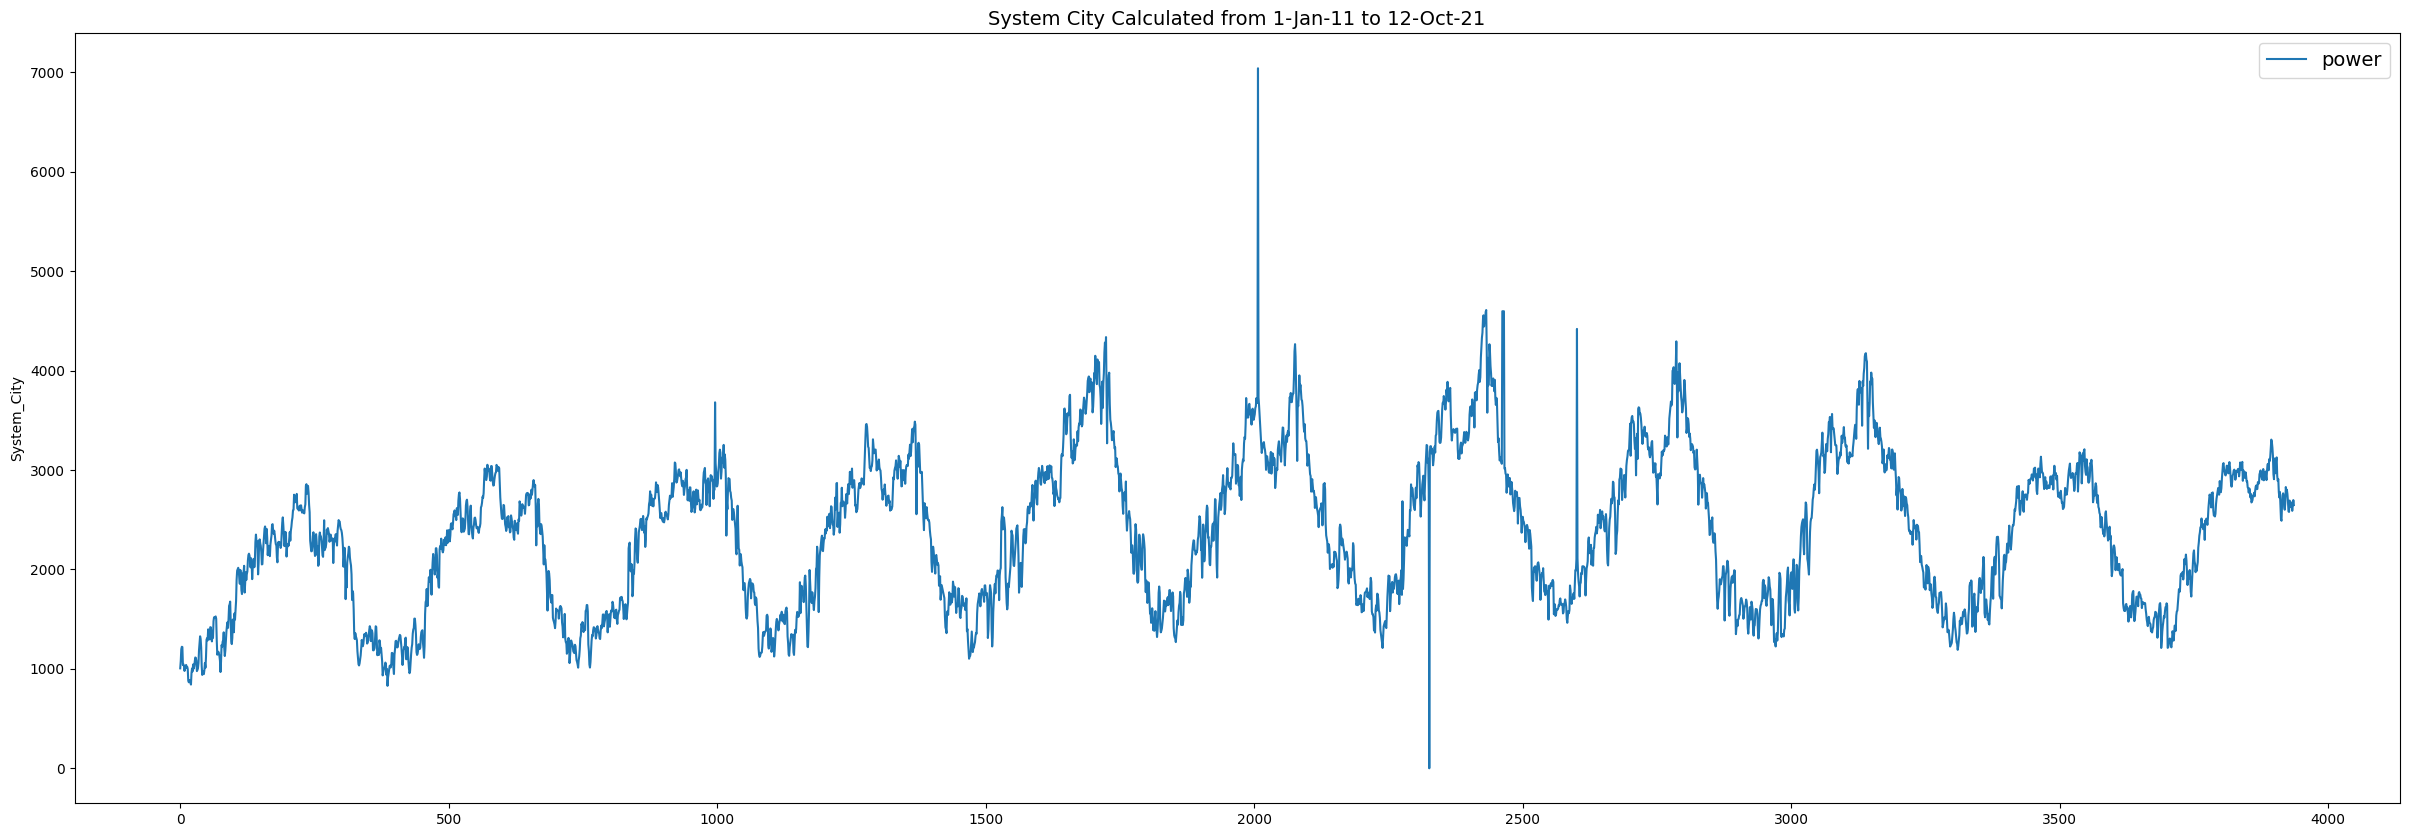

In [75]:
no_null['power'].plot(figsize=(30, 10))
plt.ylabel('System_City')
plt.title('System City Calculated from 1-Jan-11 to 12-Oct-21', fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Figure: Daily System City Power
This time-series plot shows daily 'power' from 2011-01-01 to 2021-10-12.

What to look for:
- Trend: long-term increase or decrease.
- Seasonality: repeated patterns by year/season.
- Outliers: single-day spikes/dips.


<Axes: >

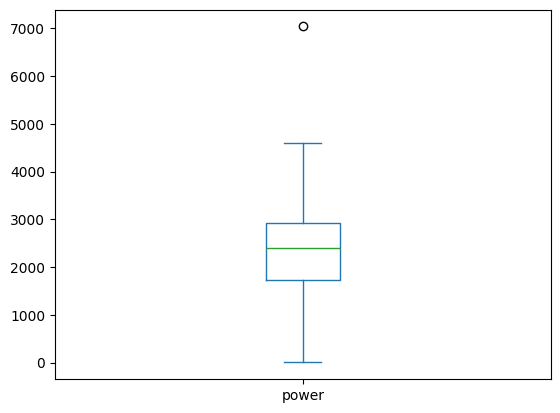

In [76]:
no_null["power"].describe()
no_null["power"].plot(kind="box")


In [77]:
df[df['power']<10]

,Date,temp,haj,ramdan,power,Population,Total_GDP
2326,2017-05-15,20.4,0,0,1.0,8575578.0,2568592


In [78]:
df[df['power']>7000]

,Date,temp,haj,ramdan,power,Population,Total_GDP
2007,2016-06-30,21.0,0,1,7040.29587,8338321.0,2587742


In [79]:
df.loc[2600:2601]

,Date,temp,haj,ramdan,power,Population,Total_GDP
2600,2018-02-13,15.0,0,0,2105.0,8803545.0,2627670
2601,2018-02-14,15.2,0,0,4419.0,8803545.0,2627670


In [80]:
df = df.drop(index=[2007, 2326, 2601])
no_null=df.dropna()
no_null

,Date,temp,haj,ramdan,power,Population,Total_GDP
0,2011-01-01,7.466667,0,0,1006.0,7244429.000,2178792
1,2011-01-02,7.866667,0,0,1079.0,7244429.000,2178792
2,2011-01-03,9.466667,0,0,1199.0,7244429.000,2178792
3,2011-01-04,7.800000,0,0,1223.0,7244429.000,2178792
4,2011-01-05,8.800000,0,0,1220.0,7244429.000,2178792
...,...,...,...,...,...,...,...
3932,2021-10-07,19.500000,0,0,2650.0,9367141.183,2613144
3933,2021-10-08,21.500000,0,0,2590.0,9367141.183,2613144
3934,2021-10-09,21.100000,0,0,2645.0,9367141.183,2613144
3935,2021-10-10,19.200000,0,0,2698.0,9367141.183,2613144


In [81]:
no_null.corr()['power']

Date          0.247190
temp          0.817850
haj           0.224085
ramdan        0.273008
power         1.000000
Population    0.221208
Total_GDP     0.318087
Name: power, dtype: float64

### Figure: Feature Correlation Heatmap
This heatmap visualizes pairwise Pearson correlations between features and 'power'.

What to look for:
- Strong positive/negative correlations (values near +1 or -1).
- Features with near-zero correlation (little linear relationship).




<Axes: >

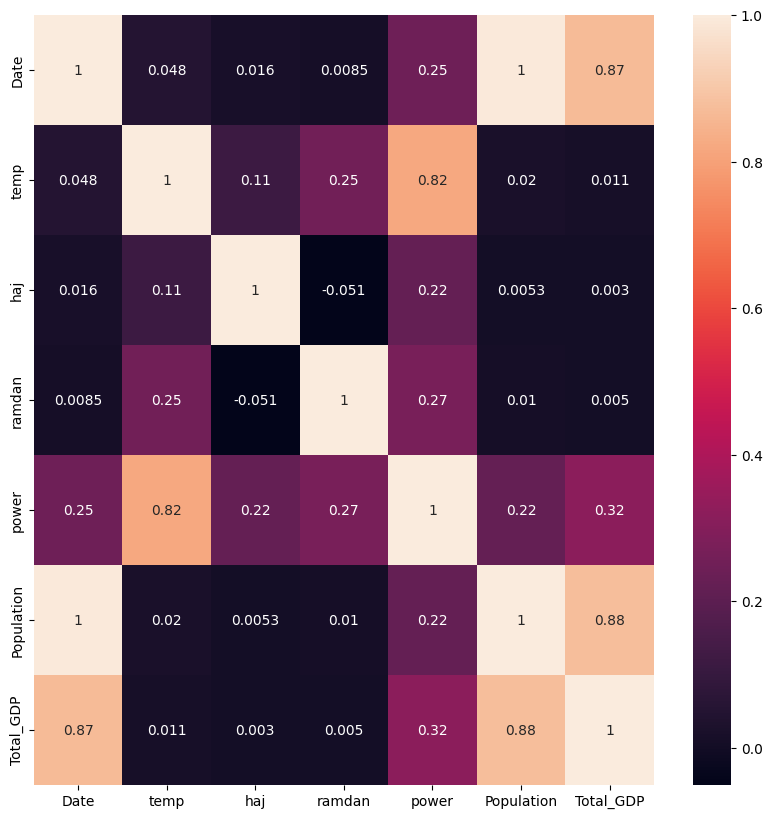

In [82]:
no_null.corr()["power"].sort_values(ascending=False)
plt.figure(figsize=(10,10))
sns.heatmap(no_null.corr(),annot=True)

<Axes: xlabel='temp', ylabel='power'>

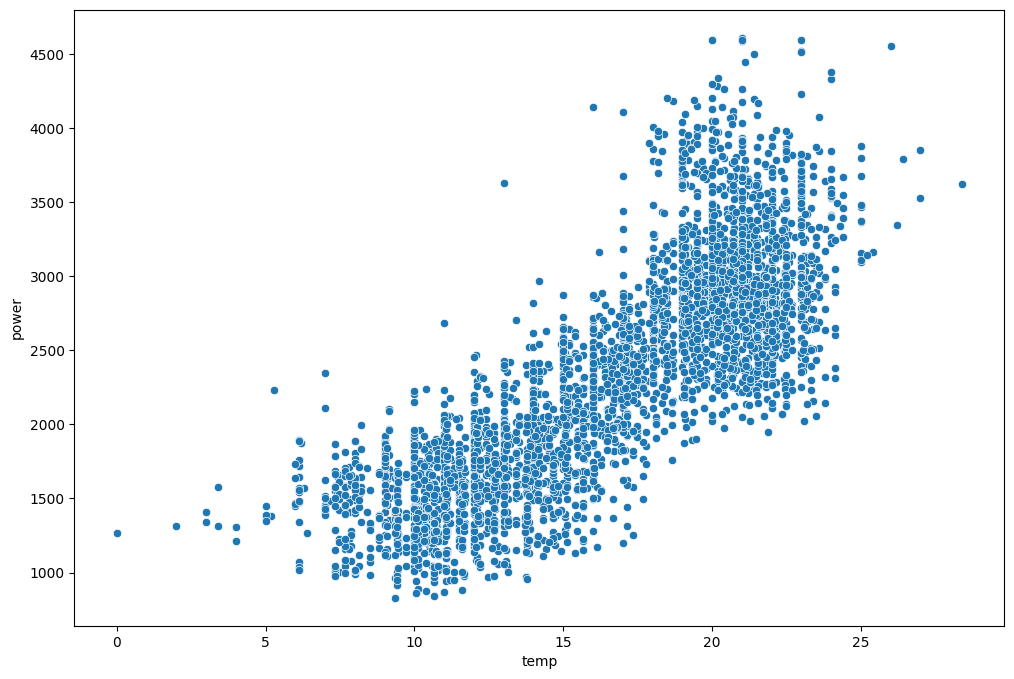

In [83]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=no_null, x="temp", y="power")

### Figure: Temperature vs Power (Scatter)
This scatter plot shows how 'temp' relates to 'power'. Look for linear trends or clusters.



In [84]:
no_null[["temp", "power"]].corr()

,temp,power
temp,1.00000,0.81785
power,0.81785,1.00000


### Figure: Temperature vs Power by Population
The hue/size encodes population: check whether higher population points correspond to higher power.

In [85]:
no_null.groupby(pd.cut(no_null["Population"], 5))["power"].mean()

/var/folders/tg/jhy0d12925ldvjghgc440mjh0000gn/T/ipykernel_48251/1551908741.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  no_null.groupby(pd.cut(no_null["Population"], 5))["power"].mean()


Population
(7242306.288, 7668971.437]    1941.119015
(7668971.437, 8093513.873]    2237.969027
(8093513.873, 8518056.31]     2608.395890
(8518056.31, 8942598.746]     2644.520604
(8942598.746, 9367141.183]    2400.925123
Name: power, dtype: float64

<Axes: xlabel='temp', ylabel='power'>

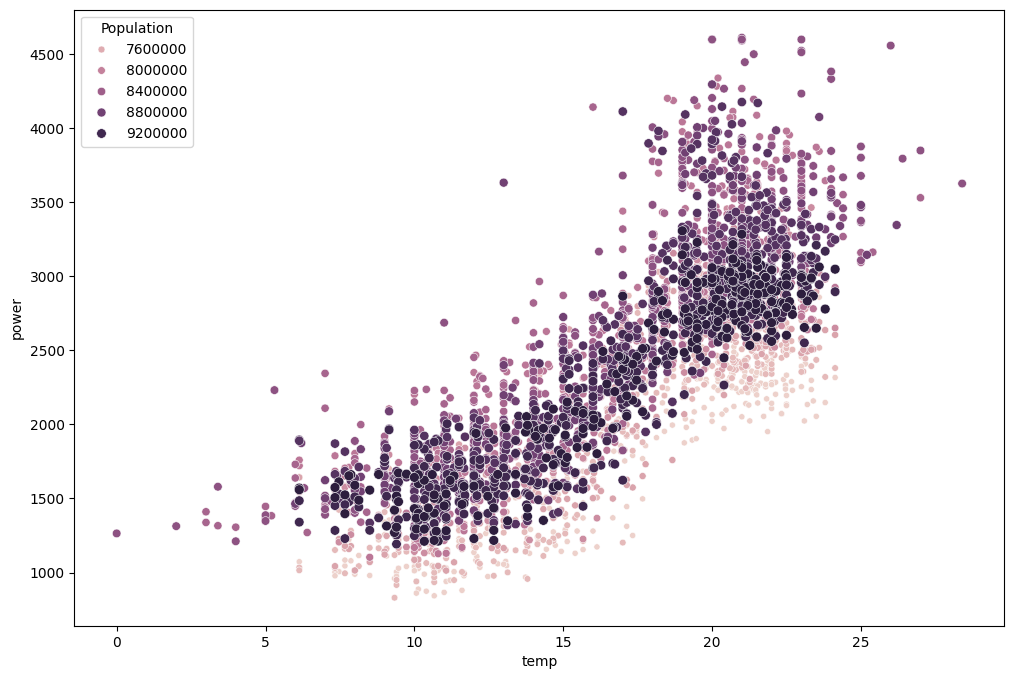

In [86]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=no_null, x="temp", y="power",hue="Population",size="Population",sizes=(20, 50))

<Axes: xlabel='Population', ylabel='power'>

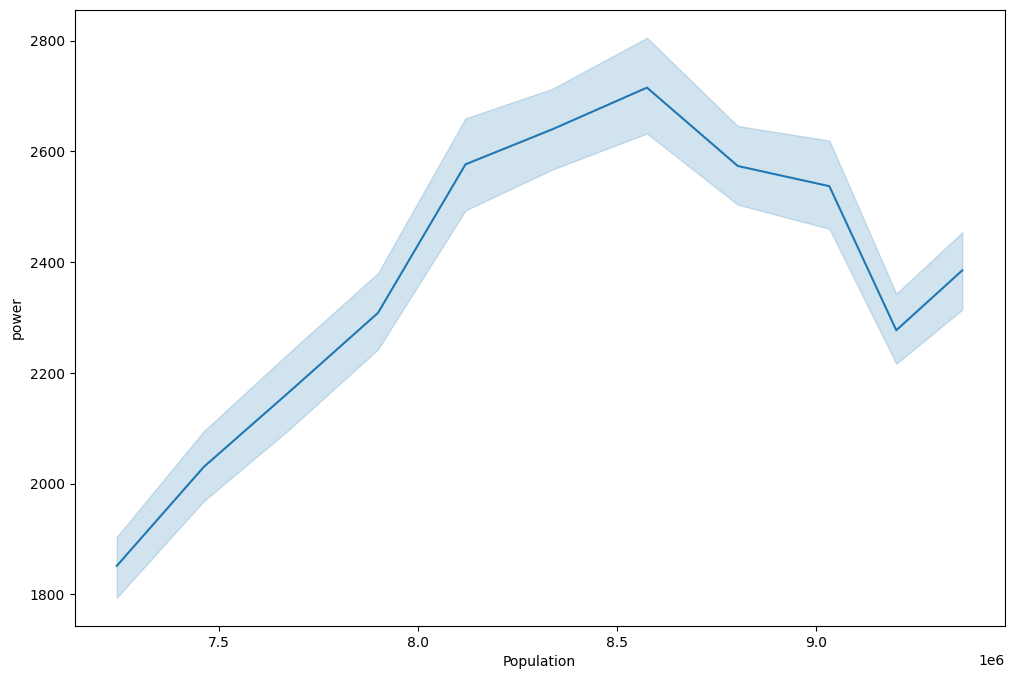

In [87]:
plt.figure(figsize=(12,8))
sns.lineplot(data=no_null, x="Population", y="power")

<Axes: xlabel='Total_GDP', ylabel='power'>

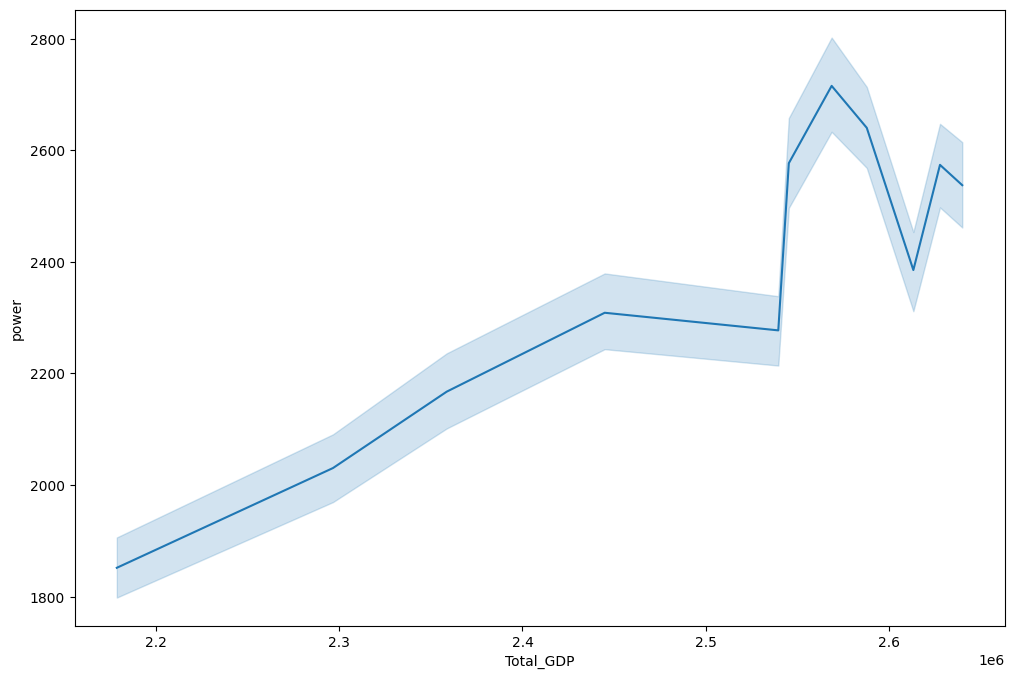

In [88]:
plt.figure(figsize=(12,8))
sns.lineplot(data=no_null, x="Total_GDP", y="power")

In [89]:
no_null.index=no_null.Date
no_null=no_null=no_null.drop('Date',axis=1)
no_null

,temp,haj,ramdan,power,Population,Total_GDP
Date,,,,,,
2011-01-01,7.466667,0,0,1006.0,7244429.000,2178792
2011-01-02,7.866667,0,0,1079.0,7244429.000,2178792
2011-01-03,9.466667,0,0,1199.0,7244429.000,2178792
2011-01-04,7.800000,0,0,1223.0,7244429.000,2178792
2011-01-05,8.800000,0,0,1220.0,7244429.000,2178792
...,...,...,...,...,...,...
2021-10-07,19.500000,0,0,2650.0,9367141.183,2613144
2021-10-08,21.500000,0,0,2590.0,9367141.183,2613144
2021-10-09,21.100000,0,0,2645.0,9367141.183,2613144


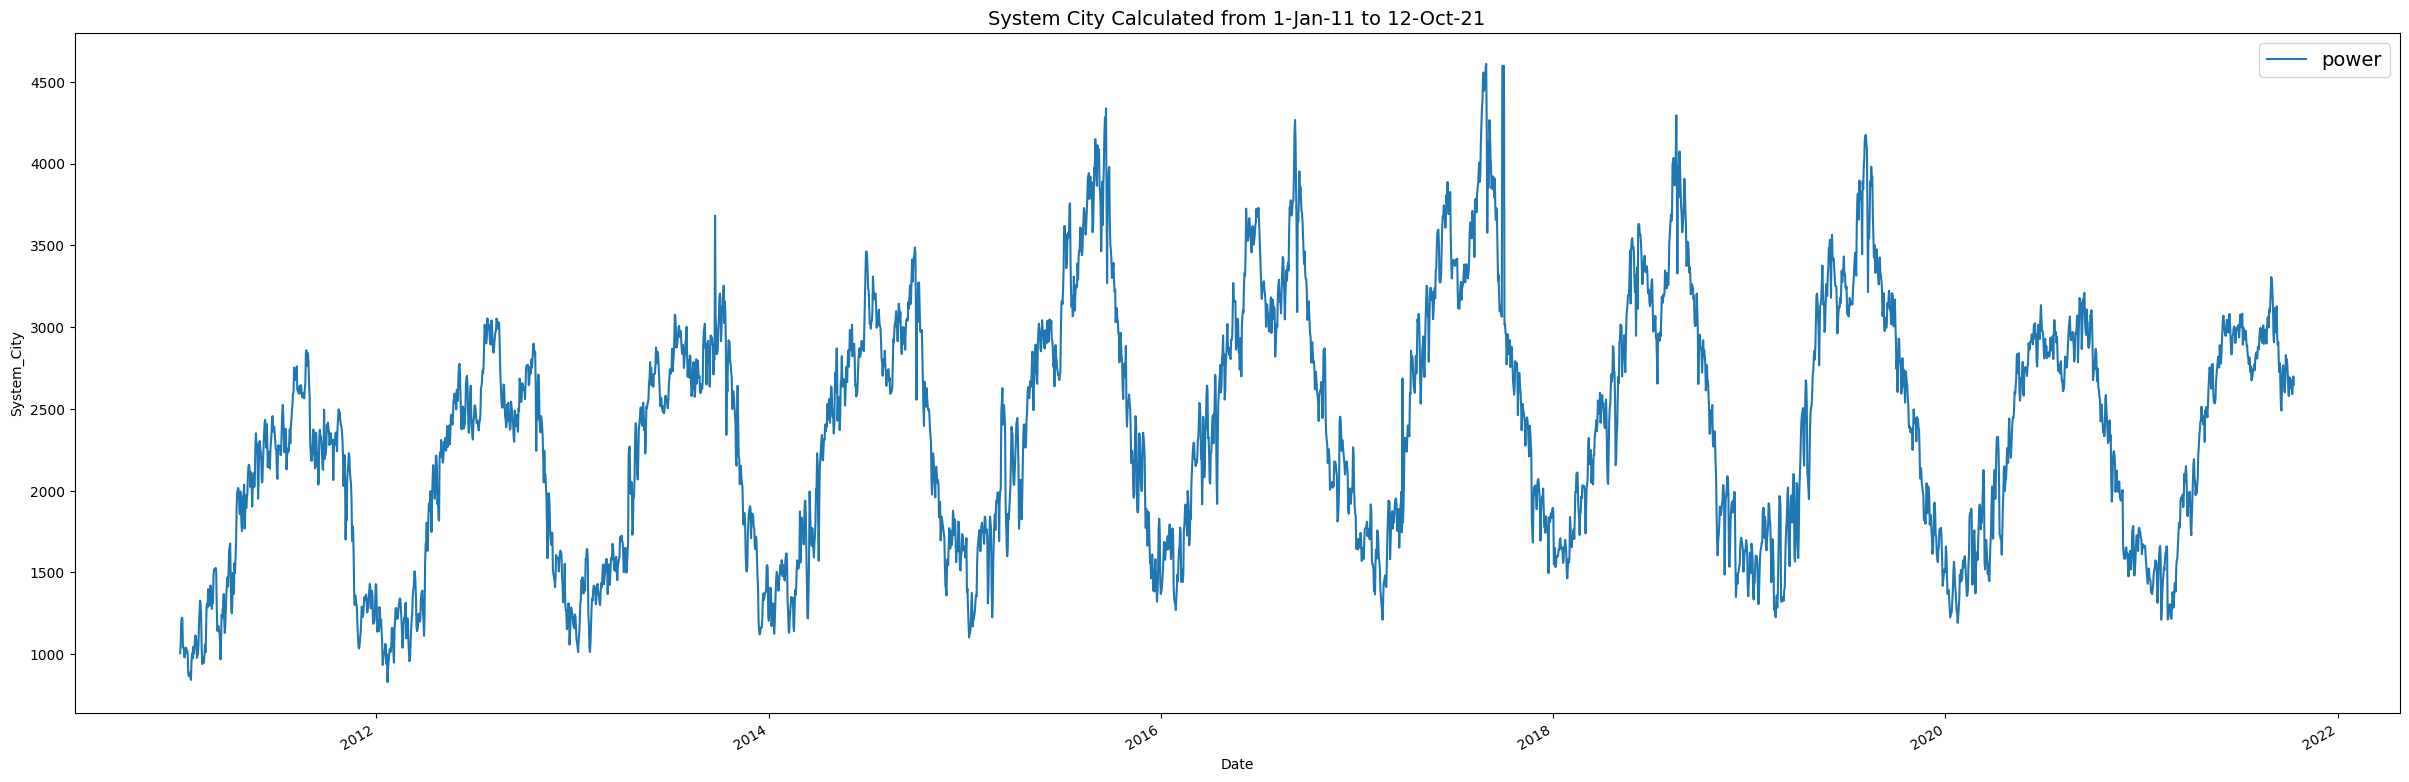

In [90]:
# Visualize the time series data
no_null['power'].plot(figsize=(30, 10))
plt.ylabel('System_City')
plt.title('System City Calculated from 1-Jan-11 to 12-Oct-21', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [91]:
df.loc[2600:2601]

,Date,temp,haj,ramdan,power,Population,Total_GDP
2600,2018-02-13,15.0,0,0,2105.0,8803545.0,2627670


In [92]:
df[df['power']>7000]

,Date,temp,haj,ramdan,power,Population,Total_GDP


In [93]:
df[df['power']<10]

,Date,temp,haj,ramdan,power,Population,Total_GDP


In [94]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(no_null.drop('power',axis=1), no_null['power'], test_size=0.2,shuffle = False, stratify = None)

In [95]:
from sklearn.linear_model import LinearRegression

In [96]:
model=LinearRegression()

In [97]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train_sc=sc.fit_transform(X_train)
X_test_sc=sc.transform(X_test)

In [98]:
model.fit(X_train_sc,y_train)

model_preds=model.predict(X_test_sc)

In [99]:
train_pred=model.predict(X_train_sc)

In [100]:
model_results = evaluate_preds(y_true=y_test, y_pred=model_preds)
model_results

{'MAE': 235.39953454079762,
 'MSE': 90340.47502329957,
 'RMSE': 300.56692270324686,
 'MAPE': 11.000139353227828,
 'MASE': 3.54900860786438}

### Model Evaluation: Linear Regression
The table below contains evaluation metrics for the model on the test set. Interpretations:
- MAE: average absolute error (same units as 'power').
- RMSE: penalizes larger errors more than MAE.
- MAPE: average percentage error (watch out for small denominators).
- MASE: scaled relative to naive forecast.

Run the cell above that prints `model_results` to see numeric values.

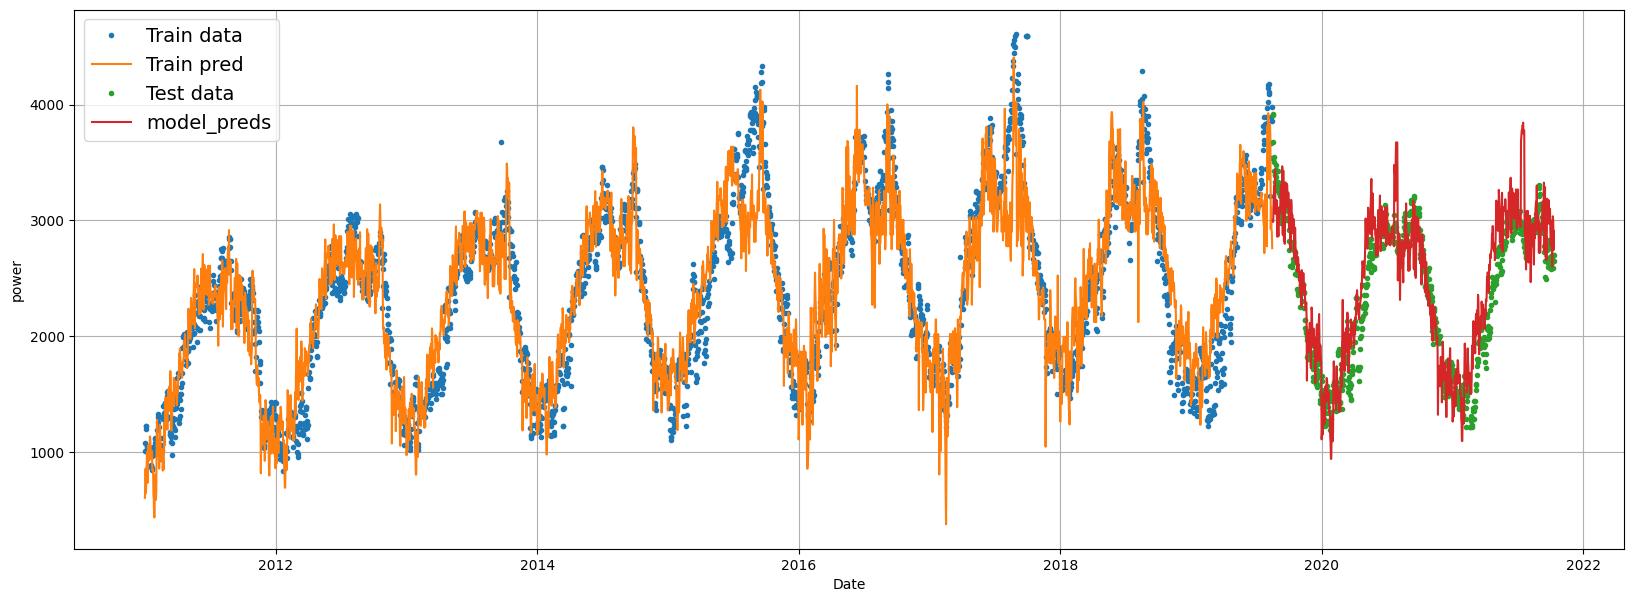

In [101]:
# Plot naive forecast
plt.figure(figsize=(20, 7))
plot_time_series(timesteps=X_train.index, values=y_train, label='Train data')
plot_time_series(timesteps=X_train.index, values=train_pred,format='-', label='Train pred')
plot_time_series(timesteps=X_test.index, values=y_test, label='Test data')
plot_time_series(timesteps=X_test.index, values=model_preds, format='-', label='model_preds')

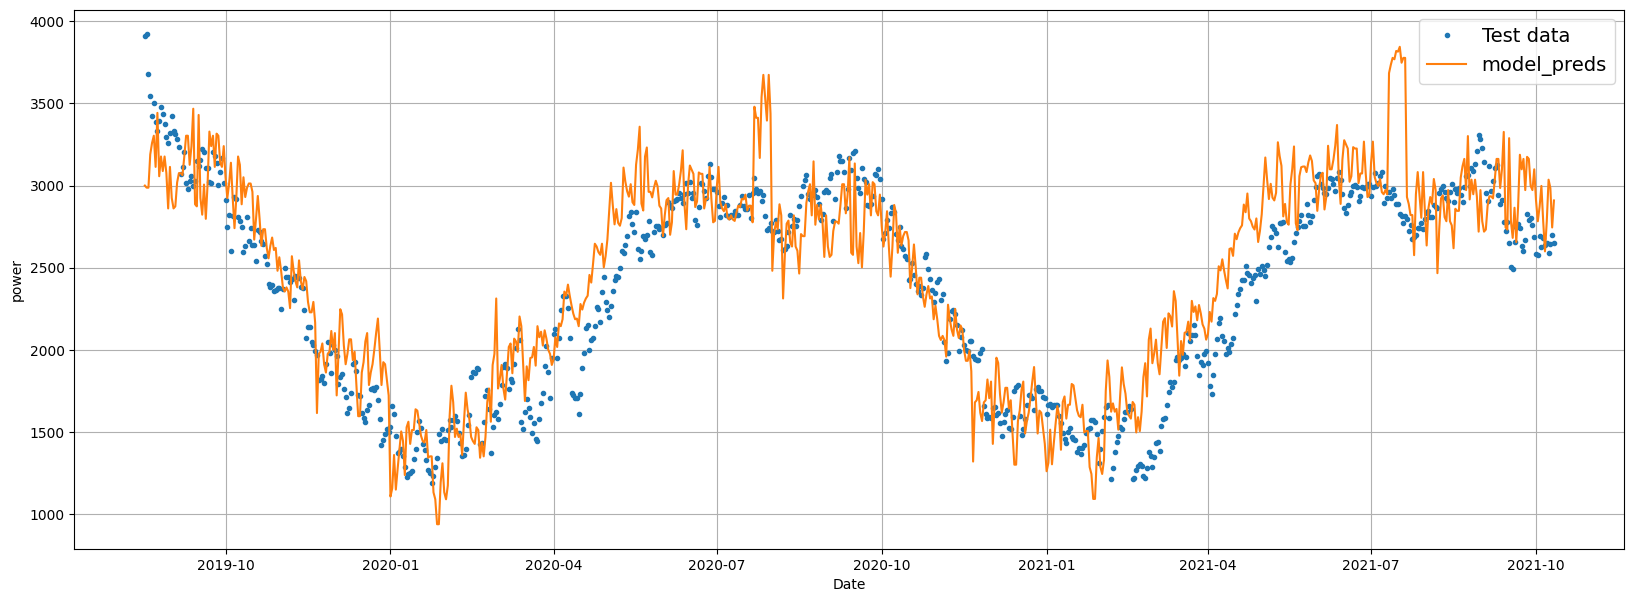

In [102]:
plt.figure(figsize=(20, 7))
plot_time_series(timesteps=X_test.index, values=y_test, label='Test data')
plot_time_series(timesteps=X_test.index, values=model_preds, format='-', label='model_preds')

In [103]:
future=df[df.isna()['power']]
future=future.drop('power',axis=1)
future

,Date,temp,haj,ramdan,Population,Total_GDP
3937,2021-10-12,19.550000,0,0,9.367141e+06,2613144
3938,2021-10-13,20.000000,0,0,9.367141e+06,2613144
3939,2021-10-14,20.200000,0,0,9.367141e+06,2613144
3940,2021-10-15,20.200000,0,0,9.367141e+06,2613144
3941,2021-10-16,19.800000,0,0,9.367141e+06,2613144
...,...,...,...,...,...,...
7881,2032-07-30,21.866667,0,0,1.099046e+07,3305117
7882,2032-07-31,20.000000,0,0,1.099046e+07,3305117
7883,2032-08-01,18.333333,0,0,1.099046e+07,3305117
7884,2032-08-02,20.133333,0,0,1.099046e+07,3305117


In [104]:
X_future=future.drop('Date',axis=1)
X_future=sc.transform(X_future)
future_preds=model.predict(X_future)

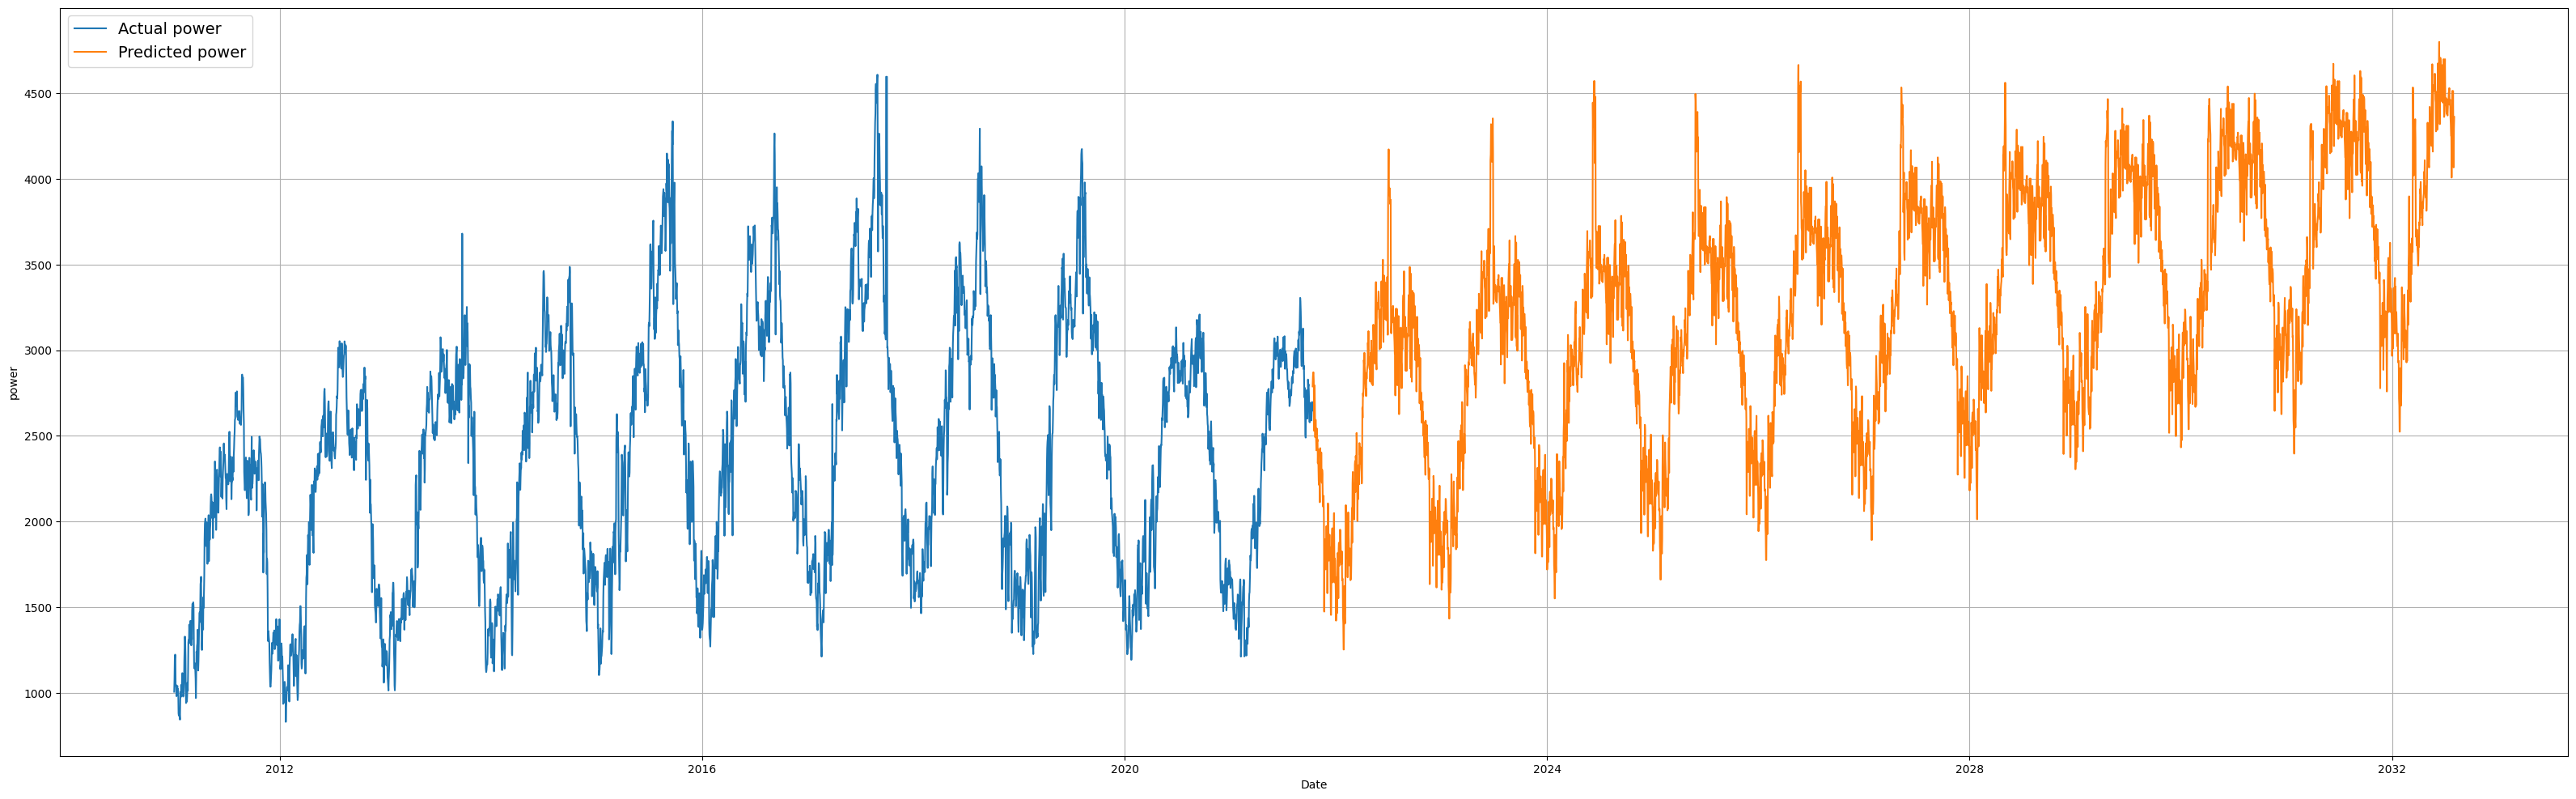

In [108]:
plt.figure(figsize=(40,12))
plot_time_series(timesteps=no_null.index, values=no_null['power'],format='-', label='Actual power')
plot_time_series(timesteps=future['Date'], values=future_preds,format='-', label='Predicted power')

### Future Predictions (Model Forecast)
This plot overlays historical actual power with the model's predictions for future dates (where 'power' was missing).



In [109]:
future_pd =pd.DataFrame({'Date':future['Date'],'power':future_preds})
future_pd

,Date,power
3937,2021-10-12,2788.890591
3938,2021-10-13,2845.794742
3939,2021-10-14,2871.085476
3940,2021-10-15,2871.085476
3941,2021-10-16,2820.504008
...,...,...
7881,2032-07-30,4514.120625
7882,2032-07-31,4278.073776
7883,2032-08-01,4067.317661
7884,2032-08-02,4294.934265


In [110]:
future_pd.set_index('Date', inplace=True)
future_pd.resample('1Y').mean()

/var/folders/tg/jhy0d12925ldvjghgc440mjh0000gn/T/ipykernel_48251/1699364543.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  future_pd.resample('1Y').mean()


,power
Date,
2021-12-31,2106.353010
2022-12-31,2636.797308
2023-12-31,2816.484324
2024-12-31,2935.154394
2025-12-31,3044.039063
2026-12-31,3159.182741
2027-12-31,3275.720571
2028-12-31,3396.128371
2029-12-31,3519.736357
